### Inroduction

In this post I want to show an example of application of Tensorflow
and a [recently released](https://research.googleblog.com/2016/08/tf-slim-high-level-library-to-define.html) library _slim_ for _Image Classification_,
_Image Annotation_ and _Segmentation_. In the post I focus on
_slim_, cover a small theoretical part and show possible applications.

I have tried other libraries before like _Caffe_, _Matconvnet_,
_Theano_ and _Torch_. All of them have their pros and cons, but I
always wanted a library in Python that is flexible, has good support and
has a lot of pretrained models. Recently, a new library called _slim_
was released along with a set of standart pretrained models like _ResNet_,
_VGG_, _Inception v3_ (new winner of ILSVRC) and others. This library along
with models are supported by Google, which makes it even better. There was a need
for a library like this because Tensorflow itself is a very low-level and any implementation
can become highly complicated. It requires writing a lot of boilerplate code.
Reading other people's code was also complicated. _slim_ is a very clean
and lightweight wrapper around Tensorflow with pretrained models.

This post assumes a prior knowledge of Tensorflow and Convolutional Neural Networks. Tensorflow has a nice tutorials on both of these.
You can find them [here](https://www.tensorflow.org/versions/r0.9/tutorials/mnist/pros/index.html).

The blog post is created using jupyter notebook. After each chunk of a code
you can see the result of its evaluation. You can also get the notebook
file from [here](http://google.com). The content of the blog post
is partially borrowed from [slim walkthough notebook](https://github.com/tensorflow/models/blob/master/slim/slim_walkthough.ipynb).

### Setup



To be able to run the code, you will need to have Tensorflow installed. I have used _r0.11_.
You will need to have _tensorflow/models_ repository cloned. To clone it, simply run:

```
git clone https://github.com/tensorflow/models
```


I am also using scikit-image library and numpy for this tutorial plus other
dependencies. One of the ways to install them is to download _Anaconda_ software
package for python.

First, we specify tensorflow to use the first GPU only. Be careful, by default it will use all
available memory. Second, we need to add the cloned repository to the path, so that python is
able to see it.

In [8]:
import sys
import os

os.environ["CUDA_VISIBLE_DEVICES"] = '0'
sys.path.append("/Users/nikhil/Documents/GitHub/Random-Repo/Tensorflow notes/models/research/slim")

Now, let's download the VGG-16 model which we will use for classification of images and segmentation. You can also use networks that will consume less memory(for example, AlexNet). For more models look [here](https://github.com/tensorflow/models/tree/master/slim#pre-trained-models). 

In [9]:
from datasets import dataset_utils
import tensorflow as tf

url = "http://download.tensorflow.org/models/vgg_16_2016_08_28.tar.gz"

# Specify where you want to download the model to
checkpoints_dir = '/Users/nikhil/Documents/GitHub/Random-Repo/Tensorflow notes/checkpoints'

if not tf.gfile.Exists(checkpoints_dir):
    tf.gfile.MakeDirs(checkpoints_dir)

dataset_utils.download_and_uncompress_tarball(url, checkpoints_dir)

>> Downloading vgg_16_2016_08_28.tar.gz 100.0%
Successfully downloaded vgg_16_2016_08_28.tar.gz 513324920 bytes.


### Image Classification

The model that we have just downloaded was trained to be able to classify images
into [1000 classes](http://image-net.org/challenges/LSVRC/2014/browse-synsets).
The set of classes is very diverse. In our blog post we will use the pretrained model
to classify, annotate and segment images into these _1000_ classes.

Below you can see an example of _Image Classification_. We preprocess the input image by
resizing it while preserving the aspect ratio and crop the central part. The size of the crop
is equal to the size of images that the network was trained on.

INFO:tensorflow:Restoring parameters from /Users/nikhil/Documents/GitHub/Random-Repo/Tensorflow notes/checkpoints/vgg_16.ckpt


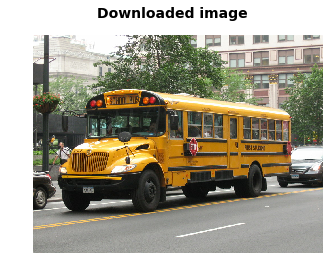

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


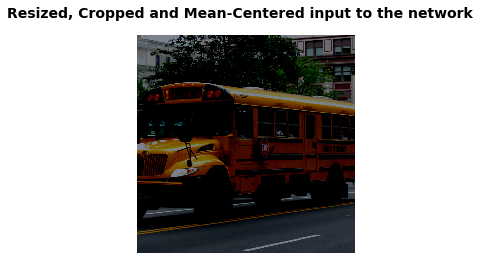

Probability 1.00 => [school bus]
Probability 0.00 => [minibus]
Probability 0.00 => [passenger car, coach, carriage]
Probability 0.00 => [trolleybus, trolley coach, trackless trolley]
Probability 0.00 => [cab, hack, taxi, taxicab]


In [14]:
%matplotlib inline

from matplotlib import pyplot as plt

import numpy as np
import os
import tensorflow as tf
import urllib

from datasets import imagenet
from nets import vgg
from preprocessing import vgg_preprocessing

checkpoints_dir = '/Users/nikhil/Documents/GitHub/Random-Repo/Tensorflow notes/checkpoints'

slim = tf.contrib.slim

# We need default size of image for a particular network.
# The network was trained on images of that size -- so we
# resize input image later in the code.
image_size = vgg.vgg_16.default_image_size


with tf.Graph().as_default():
    
    url = ("https://upload.wikimedia.org/wikipedia/commons/d/d9/"
           "First_Student_IC_school_bus_202076.jpg")
    
    # Open specified url and load image as a string
    image_string = urllib.request.urlopen(url).read()
    
    # Decode string into matrix with intensity values
    image = tf.image.decode_jpeg(image_string, channels=3)
    
    # Resize the input image, preserving the aspect ratio
    # and make a central crop of the resulted image.
    # The crop will be of the size of the default image size of
    # the network.
    processed_image = vgg_preprocessing.preprocess_image(image,
                                                         image_size,
                                                         image_size,
                                                         is_training=False)
    
    # Networks accept images in batches.
    # The first dimension usually represents the batch size.
    # In our case the batch size is one.
    processed_images  = tf.expand_dims(processed_image, 0)
    
    # Create the model, use the default arg scope to configure
    # the batch norm parameters. arg_scope is a very conveniet
    # feature of slim library -- you can define default
    # parameters for layers -- like stride, padding etc.
    with slim.arg_scope(vgg.vgg_arg_scope()):
        logits, _ = vgg.vgg_16(processed_images,
                               num_classes=1000,
                               is_training=False)
    
    # In order to get probabilities we apply softmax on the output.
    probabilities = tf.nn.softmax(logits)
    
    # Create a function that reads the network weights
    # from the checkpoint file that you downloaded.
    # We will run it in session later.
    init_fn = slim.assign_from_checkpoint_fn(
        os.path.join(checkpoints_dir, 'vgg_16.ckpt'),
        slim.get_model_variables('vgg_16'))
    
    with tf.Session() as sess:
        
        # Load weights
        init_fn(sess)
        
        # We want to get predictions, image as numpy matrix
        # and resized and cropped piece that is actually
        # being fed to the network.
        np_image, network_input, probabilities = sess.run([image,
                                                           processed_image,
                                                           probabilities])
        probabilities = probabilities[0, 0:]
        sorted_inds = [i[0] for i in sorted(enumerate(-probabilities),
                                            key=lambda x:x[1])]
    
    # Show the downloaded image
    plt.figure()
    plt.imshow(np_image.astype(np.uint8))
    plt.suptitle("Downloaded image", fontsize=14, fontweight='bold')
    plt.axis('off')
    plt.show()
    
    # Show the image that is actually being fed to the network
    # The image was resized while preserving aspect ratio and then
    # cropped. After that, the mean pixel value was subtracted from
    # each pixel of that crop. We normalize the image to be between [-1, 1]
    # to show the image.
    plt.imshow( network_input / (network_input.max() - network_input.min()) )
    plt.suptitle("Resized, Cropped and Mean-Centered input to the network",
                 fontsize=14, fontweight='bold')
    plt.axis('off')
    plt.show()

    names = imagenet.create_readable_names_for_imagenet_labels()
    for i in range(5):
        index = sorted_inds[i]
        # Now we print the top-5 predictions that the network gives us with
        # corresponding probabilities. Pay attention that the index with
        # class names is shifted by 1 -- this is because some networks
        # were trained on 1000 classes and others on 1001. VGG-16 was trained
        # on 1000 classes.
        print('Probability %0.2f => [%s]' % (probabilities[index], names[index+1]))
        
    res = slim.get_model_variables()

### Image Annotation and Segmentation



As you can see from the previous example, only a certain part 
of the original image is being processed by the network. This is good only
for cases when we want to get a single prediction for an image.

Sometimes we want to get more information from an image. For example,
it would be great to know about all the objects that are present in the
image. For example, network would tell us that it found a school bus,
other cars and building. Using this information, we can create a search
engine that will be able to give us all images that has a particular object
in them. This can be seen as a simple case of Image Annotation.

But what if we also want to get spatial information about the objects locations.
Can the network tell us that it sees a bus in the center of the image and building
on the top-right corner? That way we can create a more specific queries for a search
engine: "Give me all images where the school bus is located in the middle AND
flower pot in the top left corner".

There are cases when we need to classify each pixel of the image, also know as the task
of _Segmentation_. Imagine, that we have a huge dataset with pictures and we want to blur
faces of people there, so that we don't have to get their permission to publish these 
pictures. For example, you can see people's faces being blured in Google Street View. But
we only need to blur faces and not other content that might be important. _Segmentation_ can
help us in this case. We can get pixels that belong to faces and blur only them.

Below we will see a simple example of _Segmentation_. For the simplicity, the segmentation will
be of a smaller size than the original image. We can do segmentation using an existing Convolutional
Neural Network by applying it in a Fully Convolutional manner. This is done by casting the
Fully Connected Layers of a network into Convolutional -- this way we can input image of any size
and get segmentation of lower resolution due to max-pooling layers that are used in network. To get
the Segmentation of the same size as an input, deconvolutional layers can be used. You can
read more about this in the paper _fully convolutional networks for semantic segmentation_ by Long et al.
We won't consider deconvolutional layers in this example. Example below shows how to get segmentation of lower
resolution than the input. Deconvolutional layers can be seen as a way to perform interpolation.
Interpolation can be different (quadratic, qubic and other) but network can learn a specific
interpolation that performs well under a certain task.

Instructions for updating:
Use the `axis` argument instead
INFO:tensorflow:Restoring parameters from /Users/nikhil/Documents/GitHub/Random-Repo/Tensorflow notes/checkpoints/vgg_16.ckpt


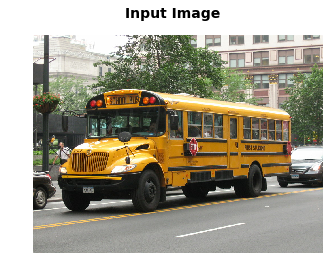

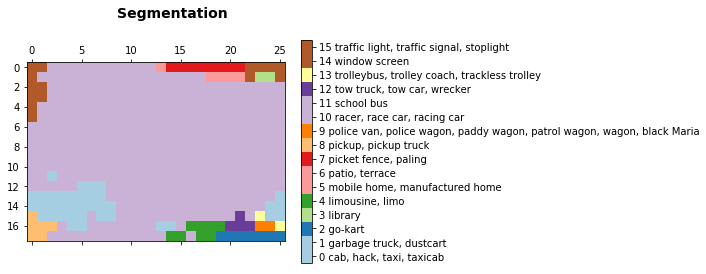

In [16]:
from preprocessing import vgg_preprocessing

# Load the mean pixel values and the function
# that performs the subtraction
from preprocessing.vgg_preprocessing import (_mean_image_subtraction,
                                            _R_MEAN, _G_MEAN, _B_MEAN)

# Function to nicely print segmentation results with
# colorbar showing class names
def discrete_matshow(data, labels_names=[], title=""):
    #get discrete colormap
    cmap = plt.get_cmap('Paired', np.max(data)-np.min(data)+1)
    # set limits .5 outside true range
    mat = plt.matshow(data,
                      cmap=cmap,
                      vmin = np.min(data)-.5,
                      vmax = np.max(data)+.5)
    #tell the colorbar to tick at integers
    cax = plt.colorbar(mat,
                       ticks=np.arange(np.min(data),np.max(data)+1))
    
    # The names to be printed aside the colorbar
    if labels_names:
        cax.ax.set_yticklabels(labels_names)
    
    if title:
        plt.suptitle(title, fontsize=14, fontweight='bold')


with tf.Graph().as_default():
    
    url = ("https://upload.wikimedia.org/wikipedia/commons/d/d9/"
           "First_Student_IC_school_bus_202076.jpg")
    
    image_string = urllib.request.urlopen(url).read()
    image = tf.image.decode_jpeg(image_string, channels=3)
    
    # Convert image to float32 before subtracting the
    # mean pixel value
    image_float = tf.to_float(image, name='ToFloat')
    
    # Subtract the mean pixel value from each pixel
    processed_image = _mean_image_subtraction(image_float,
                                              [_R_MEAN, _G_MEAN, _B_MEAN])

    input_image = tf.expand_dims(processed_image, 0)
    
    with slim.arg_scope(vgg.vgg_arg_scope()):
        
        # spatial_squeeze option enables to use network in a fully
        # convolutional manner
        logits, _ = vgg.vgg_16(input_image,
                               num_classes=1000,
                               is_training=False,
                               spatial_squeeze=False)
    
    # For each pixel we get predictions for each class
    # out of 1000. We need to pick the one with the highest
    # probability. To be more precise, these are not probabilities,
    # because we didn't apply softmax. But if we pick a class
    # with the highest value it will be equivalent to picking
    # the highest value after applying softmax
    pred = tf.argmax(logits, dimension=3)
    
    init_fn = slim.assign_from_checkpoint_fn(
        os.path.join(checkpoints_dir, 'vgg_16.ckpt'),
        slim.get_model_variables('vgg_16'))
    
    with tf.Session() as sess:
        init_fn(sess)
        segmentation, np_image = sess.run([pred, image])

# Remove the first empty dimension
segmentation = np.squeeze(segmentation)

# Let's get unique predicted classes (from 0 to 1000) and
# relable the original predictions so that classes are
# numerated starting from zero
unique_classes, relabeled_image = np.unique(segmentation,
                                            return_inverse=True)

segmentation_size = segmentation.shape

relabeled_image = relabeled_image.reshape(segmentation_size)

labels_names = []

for index, current_class_number in enumerate(unique_classes):

    labels_names.append(str(index) + ' ' + names[current_class_number+1])

# Show the downloaded image
plt.figure()
plt.imshow(np_image.astype(np.uint8))
plt.suptitle("Input Image", fontsize=14, fontweight='bold')
plt.axis('off')
plt.show()

discrete_matshow(data=relabeled_image, labels_names=labels_names, title="Segmentation")



The segmentation that was obtained shows that network was able to find
the school bus, traffic sign in the left-top corner that can't be clearly
seen in the image. It was able to locate windows at the top-left corner and even
made a hypothesis that it is a library (we don't know if that is true). It also made
a certain number of not so correct predictions. Those are usually caused by the fact
that the network can only see a part of image when it is centered at a pixel. The 
characteristic of a network that represents it is called _receptive field_. Receptive
field of the network that we use in this blog is _404_ pixels. So when network can
only see a part of the school bus, it confuses it with taxi or pickup truck. You can
see that in the bottom-left corner of segmentation results. 

As we can see above, we got a simple segmentation for our image. It is not
very precise because the network was originally trained to perform classification
and not segmentation. If we want to get better results, we will have to train it ourselves.
Anyways, the results that we got are suitable for image annotation and very approximate segmentation.

Performing Segmentation using Convolutional Neural Networks can be seen as performing classification
at different parts of an input image. We center network at a particular pixel, make prediction and
assign label to that pixel. This way we add spatial information to our classification and get
segmentation.

### Conclusion and Discussion

In this blog post we covered _slim_ library by performing _Image Classification_ and
_Segmentation_. The post also explains a certain amount of theory behind both tasks.

In my opinion, _slim_ along with pretrained models can be a very powerful tool while
remaining very flexible and you can always intermix Tensorflow with it. It is relatively
new, therefore, it lacks documentation and sometimes you have to read the source code. It has support
from Google and is currently in an active development. 